# Exploratory Data Analysis (EDA)

**Carlos Bustillo | Prosigliere Tech Interview**
<br>I'm using GPU T4 on Google Colab

## 0) Dependencies

In [1]:
import os
import glob
import joblib

import logging
from dataclasses import dataclass, field
from typing import List, Dict, Any

import numpy as np
import pandas as pd

from scipy.signal import butter, filtfilt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GroupShuffleSplit

import matplotlib.pyplot as plt
import seaborn as sns

## 1) Config params

**Access to Google Drive folders**

If you are in local (your computer), this block is not necessary

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Configuration with dataclass**

In [3]:
@dataclass
class Config:

    # Path to your dataset
    dataset_path: str = "/content/drive/MyDrive/Prosigliere/AI_ML_Challenge"

    # "…sensors recording at 128 Hz at 7 body locations…" -> It was extracted from the paper.
    sampling_rate_hz: int = 128

    # 2.5 * 128 = 320 samples
    window_seconds: float = 2.5
    # 1.5 * 128 = 192 samples
    overlap_seconds: float = 1.5

    locations: List[str] = field(default_factory=lambda: [
        'r.ankle','l.ankle','r.thigh','l.thigh','head','sternum','waist'
    ])
    trial_types: Dict[str,int] = field(default_factory=lambda: {
        'ADLs':0,'Falls':1,'Near_Falls':2
    })
    eda_output_dir: str = "eda_outputs"

    # Low pass filter
    lowpass_cutoff: float = 20.0
    lowpass_order: int = 4

    @property
    def window_size(self) -> int:
        return int(self.window_seconds * self.sampling_rate_hz)

    @property
    def step_size(self) -> int:
        return self.window_size - int(self.overlap_seconds * self.sampling_rate_hz)

In [4]:
cfg = Config()

**Logging**

In [5]:
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s"
)
logger = logging.getLogger()

## 2) Load the data

**Load all the xlsx files into a dataframe**

In [6]:
def load_data(path: str) -> pd.DataFrame:
    trials = []

    for subdir in sorted(glob.glob(os.path.join(path, "sub*"))):
        subject = os.path.basename(subdir)
        for ttype,label in cfg.trial_types.items():
            for f in glob.glob(os.path.join(subdir, ttype, "*.xlsx")):
                try:
                    df = pd.read_excel(f)
                    df['subject']=subject
                    df['trial_type']=ttype
                    df['label']=label
                    trials.append(df)
                except Exception as e:
                    logger.warning(f"Error reading {f}: {e}")

    if not trials:
        raise FileNotFoundError("No .xlsx files were found.")

    data = pd.concat(trials, ignore_index=True)
    logger.info(f"The files were loaded: {data.shape}")

    return data

This took ~19 minutes

In [7]:
data_raw = load_data(cfg.dataset_path)

## 3) Preprocessing

**Butterworth Low Pass Filter**

In [8]:
def butter_lowpass_filter(data, cutoff, fs, order):

    b,a = butter(order, cutoff/(0.5*fs), btype='low')

    return filtfilt(b, a, data)

**Preprocessing**

In [9]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    logger.info("Preprocessing starts now...")

    # Convert and infer types
    df['timestamp'] = pd.to_datetime(df['Time'], unit='us')
    df = df.infer_objects()

    # Time‑based interpolation
    df = df.set_index('timestamp')
    df.interpolate(method='time', limit_direction='both', inplace=True)
    df = df.reset_index()

    # Fill NaN values
    df.ffill(inplace=True)
    df.bfill(inplace=True)

    # Restore index & compute Time_s
    df['Time_s'] = df.index.astype(int) / 1e9
    df = df.reset_index(drop=False)

    # Filtering noise in magnetometers
    # "Magnetic field data from the sternum and waist sensors may be noisier than data from other sensors."
    for loc in ['sternum','waist']:
        for ax in ['X','Y','Z']:
            col = f"{loc} Magnetic Field {ax} (uT)"
            if col in df:
                df[col] = butter_lowpass_filter(
                    df[col].values,
                    cfg.lowpass_cutoff,
                    cfg.sampling_rate_hz,
                    cfg.lowpass_order
                )

    logger.info("The preprocessing was completed.")

    return df

In [10]:
data_pre = preprocess(data_raw)

/tmp/ipython-input-9-3872705236.py:10: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(method='time', limit_direction='both', inplace=True)


## 4) Exploratory Data Analysis (EDA)

**Create output folders for EDA**

In [11]:
os.makedirs(cfg.eda_output_dir, exist_ok=True)

**Missing values**

In [12]:
tab_missing = data_pre.isna().sum().to_frame('missing_count')
tab_missing.to_csv(os.path.join(cfg.eda_output_dir,'missing_values.csv'))

**Class Balance**

In [13]:
counts = data_pre['trial_type'].value_counts()
percents = data_pre['trial_type'].value_counts(normalize=True)*100

pd.DataFrame({'count':counts,'percent':percents})\
  .to_csv(os.path.join(cfg.eda_output_dir,'class_balance.csv'))

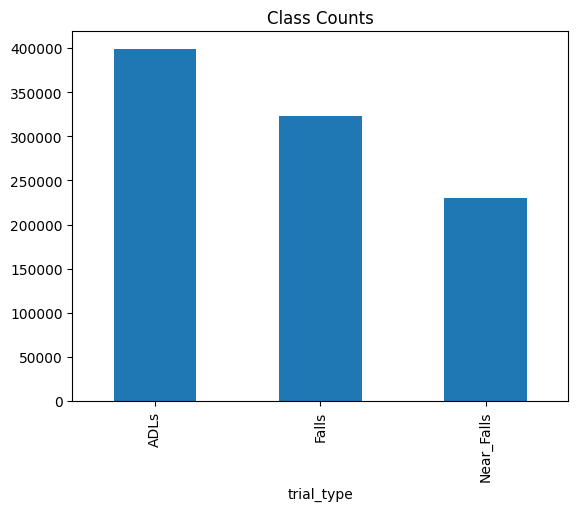

In [14]:
plt.figure()
counts.plot(kind='bar')
plt.title('Class Counts')
plt.savefig(os.path.join(cfg.eda_output_dir,'class_counts.png'))

**Example Time Series**

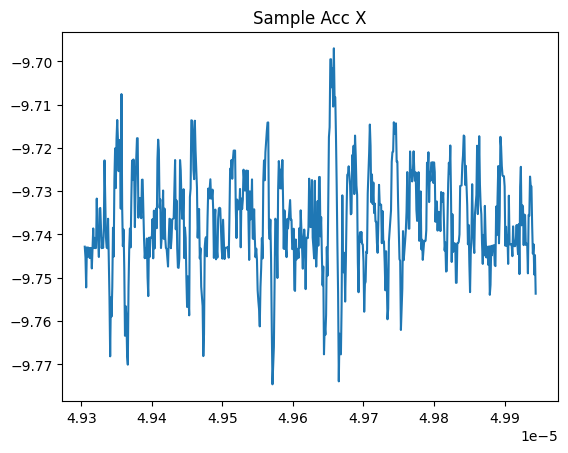

In [15]:
first_sub = data_pre[data_pre['trial_type']=='Falls']['subject'].iloc[0]
win = data_pre[(data_pre['subject']==first_sub)&(data_pre['trial_type']=='Falls')].iloc[:cfg.sampling_rate_hz*5]

plt.figure()
plt.plot(win['Time_s'], win[f"{cfg.locations[0]} Acceleration X (m/s^2)"])
plt.title('Sample Acc X')
plt.savefig(os.path.join(cfg.eda_output_dir,'sample_ts.png'))

**Histograms and Outliers of Magnitudes**

In [16]:
for loc in cfg.locations:
    cols = [f"{loc} Acceleration {ax} (m/s^2)" for ax in ['X','Y','Z']]
    if all(c in data_pre for c in cols):
        data_pre[f"{loc}_acc_mag"] = np.linalg.norm(data_pre[cols],axis=1)

mag_cols = [c for c in data_pre if c.endswith('_acc_mag')]

In [17]:
outlier_summary={}

for c in mag_cols:
    series=data_pre[c].dropna()

    sns.histplot(series,bins=50,kde=True)
    plt.title(c)
    plt.savefig(os.path.join(cfg.eda_output_dir,f'hist_{c}.png'))
    plt.close()

    Q1,Q3=series.quantile([0.25,0.75]); IQR=Q3-Q1
    mask=(series<(Q1-1.5*IQR))|(series>(Q3+1.5*IQR))
    outlier_summary[c]=mask.sum()

    sns.boxplot(x=series)
    plt.title(f'Boxplot {c}')
    plt.savefig(os.path.join(cfg.eda_output_dir,f'box_{c}.png'))
    plt.close()

In [18]:
pd.Series(outlier_summary,name='outliers').to_csv(os.path.join(cfg.eda_output_dir,'outliers.csv'))

**Correlation**

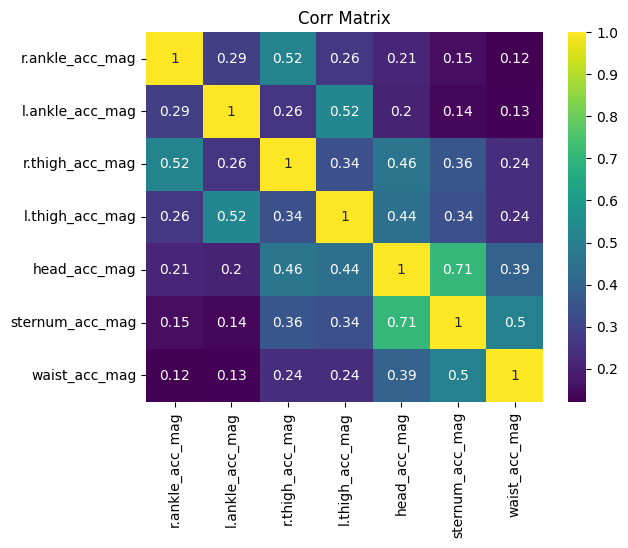

In [19]:
corr=data_pre[mag_cols].corr()

sns.heatmap(corr, cmap='viridis', annot=True)
plt.title('Corr Matrix')
plt.savefig(os.path.join(cfg.eda_output_dir,'corr_matrix.png'))

## 5) Feature Extraction and Split

**Feature extraction function using sliding windows**

Sliding-window feature extraction:
- For each subject & trial_type, slide a window of cfg.window_size over the data with step cfg.step_size
- Compute mean and variance of the 3 axis magnitude for Acceleration, Angular Velocity, Magnetic Field
- **This is a problem of binary classification:** Label = 1 for Falls, 0 otherwise

In [20]:
def extract_features(df: pd.DataFrame, cfg: Config) -> pd.DataFrame:
    records = []

    # Map measure -> unit suffix
    unit_map = {
        'Acceleration':    '(m/s^2)',
        'Angular Velocity':'(rad/s)',
        'Magnetic Field':  '(uT)'
    }

    for (subj, ttype), seg in df.groupby(['subject','trial_type']):
        seg = seg.reset_index(drop=True)
        n_samples = len(seg)
        for start in range(0, n_samples - cfg.window_size + 1, cfg.step_size):
            window = seg.iloc[start:start + cfg.window_size]
            feats = {}

            # Calculate mean and variance of magnitude per sensor and type
            for loc in cfg.locations:
                for measure, unit in unit_map.items():
                    # Build the exact column names -> Example "r.ankle Acceleration X (m/s^2)"
                    cols = [f"{loc} {measure} {ax} {unit}" for ax in ['X','Y','Z']]
                    if all(col in window.columns for col in cols):
                        vals = window[cols].values  # shape (window_size, 3)
                        mag = np.linalg.norm(vals, axis=1)
                        feats[f"{loc}_{measure}_mag_mean"] = mag.mean()
                        feats[f"{loc}_{measure}_mag_var"]  = mag.var()
                    else:
                        # Catch missing columns
                        missing = [col for col in cols if col not in window.columns]
                        print(f"Missing columns for {loc} {measure}: {missing}")

            # Assign label and subject
            feats['label']   = int(cfg.trial_types[ttype] == 1)
            feats['subject'] = subj

            records.append(feats)

    feat_df = pd.DataFrame(records)

    # Sanity check
    if feat_df.shape[1] <= 2:
        raise RuntimeError("No feature columns extracted -> check column names in unit_map")

    return feat_df

In [21]:
features_df = extract_features(data_pre, cfg)

Save features for inspection

In [22]:
features_df.to_csv('features_windows.csv', index=False)

**Splitting and scaling**

Check how many windows per subject

In [23]:
print(features_df['subject'].value_counts())

subject
sub2    924
sub3    924
sub4    924
sub5    924
sub7    924
sub6    924
sub8    924
sub1    919
Name: count, dtype: int64


In [24]:
print(repr(list(features_df['subject'].unique())))

['sub1', 'sub2', 'sub3', 'sub4', 'sub5', 'sub6', 'sub7', 'sub8']


In [25]:
# 1) Get clean unique subjects
subs = features_df['subject'].unique()

# 2) Split them into train/val/test lists
train_subj, test_subj = train_test_split(subs, test_size=0.2, random_state=42)
train_subj, val_subj  = train_test_split(train_subj, test_size=0.25, random_state=42)

print("Train subjects:", train_subj)
print("Val   subjects:", val_subj)
print("Test  subjects:", test_subj)

# 3) Slice by boolean mask
X = features_df.drop(columns=['label','subject'])
y = features_df['label']

X_train = X[features_df['subject'].isin(train_subj)]
y_train = y[features_df['subject'].isin(train_subj)]

X_val   = X[features_df['subject'].isin(val_subj)]
y_val   = y[features_df['subject'].isin(val_subj)]

X_test  = X[features_df['subject'].isin(test_subj)]
y_test  = y[features_df['subject'].isin(test_subj)]

# 4) Check none are empty
for name, Xs in [('train',X_train),('val',X_val),('test',X_test)]:
    print(f"{name} split shape: {Xs.shape}")

# 5) Scale
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val   = pd.DataFrame(scaler.transform(X_val),   columns=X_val.columns)
X_test  = pd.DataFrame(scaler.transform(X_test),  columns=X_test.columns)

Train subjects: ['sub7' 'sub3' 'sub4' 'sub5']
Val   subjects: ['sub1' 'sub8']
Test  subjects: ['sub2' 'sub6']
train split shape: (3696, 42)
val split shape: (1843, 42)
test split shape: (1848, 42)


View resulting shapes

In [26]:
sets = {
    'X_train': X_train,
    'y_train': y_train,
    'X_val':   X_val,
    'y_val':   y_val,
    'X_test':  X_test,
    'y_test':  y_test
}

In [27]:
display({k: v.shape for k,v in sets.items()})

{'X_train': (3696, 42),
 'y_train': (3696,),
 'X_val': (1843, 42),
 'y_val': (1843,),
 'X_test': (1848, 42),
 'y_test': (1848,)}

## 6) Saving data for training phase

Create folder to save data

In [28]:
processed_dir = 'processed_data'
os.makedirs(processed_dir, exist_ok=True)

Save them as joblib (Binary, it's faster for big dataframes)

In [29]:
joblib.dump(sets['X_train'], os.path.join(processed_dir, 'X_train.joblib'))
joblib.dump(sets['y_train'], os.path.join(processed_dir, 'y_train.joblib'))
joblib.dump(sets['X_val'],   os.path.join(processed_dir, 'X_val.joblib'))
joblib.dump(sets['y_val'],   os.path.join(processed_dir, 'y_val.joblib'))
joblib.dump(sets['X_test'],  os.path.join(processed_dir, 'X_test.joblib'))
joblib.dump(sets['y_test'],  os.path.join(processed_dir, 'y_test.joblib'))

print("All datasets saved to:", processed_dir)

All datasets saved to: processed_data


**Zip folders to download them**
<br>If you are in local (your computer), this block is not necessary

In [30]:
!zip -r eda_outputs.zip /content/eda_outputs
!zip -r processed_data.zip /content/processed_data

updating: content/eda_outputs/ (stored 0%)
updating: content/eda_outputs/corr_matrix.png (deflated 8%)
updating: content/eda_outputs/hist_l.ankle_acc_mag.png (deflated 12%)
updating: content/eda_outputs/hist_l.thigh_acc_mag.png (deflated 13%)
updating: content/eda_outputs/box_sternum_acc_mag.png (deflated 23%)
updating: content/eda_outputs/hist_waist_acc_mag.png (deflated 14%)
updating: content/eda_outputs/box_r.ankle_acc_mag.png (deflated 24%)
updating: content/eda_outputs/box_head_acc_mag.png (deflated 23%)
updating: content/eda_outputs/box_r.thigh_acc_mag.png (deflated 24%)
updating: content/eda_outputs/missing_values.csv (deflated 85%)
updating: content/eda_outputs/hist_r.ankle_acc_mag.png (deflated 13%)
updating: content/eda_outputs/sample_ts.png (deflated 4%)
updating: content/eda_outputs/box_l.ankle_acc_mag.png (deflated 24%)
updating: content/eda_outputs/outliers.csv (deflated 42%)
updating: content/eda_outputs/box_l.thigh_acc_mag.png (deflated 24%)
updating: content/eda_output